# Field Extrapolation Testing

In [1]:
from collections import namedtuple
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import yt
import numba
import solarbextrapolation.extrapolators
import sunpy.map
import sunpy
import sunpy.coordinates
from sunpy.image.rescale import resample
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar

import synthesizAR.extrapolate
import synthesizAR.util

%matplotlib inline

First, implement method for doing classical Schmidt extrapolation.

In [ ]:
SpatialPair = namedtuple('SpatialPair', 'x y z')

In [ ]:
class ClassicalSchmidt(object):
    
    @u.quantity_input
    def __init__(self, magnetogram, width_z: u.cm, shape_z: u.pixel):
        self.magnetogram = magnetogram
        self.shape = SpatialPair(x=magnetogram.dimensions.x,y=magnetogram.dimensions.y,z=shape_z)
        range_x,range_y = self._calculate_range(magnetogram)
        range_z = u.Quantity([0*u.cm, width_z])
        self.range = SpatialPair(x=range_x.to(u.cm),y=range_y.to(u.cm),z=range_z.to(u.cm))
        width_x = np.diff(range_x)[0]
        width_y = np.diff(range_y)[0]
        self.width = SpatialPair(x=width_x.to(u.cm),y=width_y.to(u.cm),z=width_z.to(u.cm))
        self.delta = SpatialPair(x=self.width.x/self.shape.x,y=self.width.y/self.shape.y,z=self.width.z/self.shape.z)
        
    def _calculate_range(self,magnetogram):
        left_corner = synthesizAR.extrapolate.heeq_to_local(
                        *u.Quantity(synthesizAR.util.to_heeq(
                            magnetogram.bottom_left_coord))[:,np.newaxis],magnetogram.center)
        right_corner = synthesizAR.extrapolate.heeq_to_local(
                        *u.Quantity(synthesizAR.util.to_heeq(
                            magnetogram.top_right_coord))[:,np.newaxis],magnetogram.center)
        range_x = u.Quantity([left_corner[0][0], right_corner[0][0]])
        range_y = u.Quantity([left_corner[1][0], right_corner[1][0]])
        return range_x, range_y
    
    def project_boundary(self, range_x, range_y):
        """
        Project the magnetogram onto a plane normal to the surface
        """
        # Get all points in local, rotated coordinate system
        p_y,p_x = np.indices((int(self.shape.x.value), int(self.shape.y.value)))
        pixels = u.Quantity([(i_x,i_y) for i_x,i_y in zip(p_x.flatten(),p_y.flatten())],'pixel')
        world_coords = self.magnetogram.pixel_to_world(pixels[:,0],pixels[:,1])
        local_x,local_y,_ = synthesizAR.extrapolate.heeq_to_local(
                                    *u.Quantity(synthesizAR.util.to_heeq(world_coords)),
                                    self.magnetogram.center)
        # Flatten
        points = np.stack([local_x.to(u.cm).value,local_y.to(u.cm).value],axis=1)
        values = u.Quantity(self.magnetogram.data, self.magnetogram.meta['bunit']).value.flatten()
        # Interpolate
        x_new = np.linspace(range_x[0], range_x[1], int(self.shape.x.value))
        y_new = np.linspace(range_y[0], range_y[1], int(self.shape.y.value))
        x_grid,y_grid = np.meshgrid(x_new.to(u.cm).value, y_new.to(u.cm).value)
        boundary_interp = scipy.interpolate.griddata(points, values, (x_grid, y_grid), fill_value=0.)
        
        return u.Quantity(boundary_interp, self.magnetogram.meta['bunit'])
    
    @property
    def line_of_sight(self):
        """
        LOS vector in the local coordinate system
        """
        l_hat = self.magnetogram.observer_coordinate.transform_to(
                    sunpy.coordinates.frames.Heliocentric(observer=self.magnetogram.observer_coordinate))
        l_hat = synthesizAR.extrapolate.heeq_to_local(
                    *u.Quantity(synthesizAR.util.to_heeq(l_hat))[:,np.newaxis],
                    self.magnetogram.center)
        return np.squeeze(u.Quantity(l_hat))
        
    
    def calculate_phi(self):
        """
        Calculate potential
        """
        # Set up grid
        y_grid,x_grid = np.indices((int(self.shape.x.value), int(self.shape.y.value)))
        x_grid = x_grid*self.delta.x.value
        y_grid = y_grid*self.delta.y.value
        z_depth = -self.delta.z.value/np.sqrt(2.*np.pi)
        
        # Project lower boundary
        boundary = self.project_boundary(self.range.x, self.range.y).value
        
        # Normalized LOS vector
        l_hat = (self.line_of_sight/np.sqrt((self.line_of_sight**2).sum())).value
        
        # Calculate phi
        delta = SpatialPair(x=self.delta.x.value,y=self.delta.y.value,z=self.delta.z.value)
        shape = SpatialPair(x=int(self.shape.x.value),
                            y=int(self.shape.y.value),
                            z=int(self.shape.z.value))
        phi = numba.decorators.jit(self._calculate_phi,nopython=True)(boundary, delta, shape, z_depth, l_hat)
                    
        return phi * u.Unit(self.magnetogram.meta['bunit']) * self.delta.x.unit * (1. * u.pixel)
    
    @staticmethod
    def _calculate_phi(boundary, delta, shape, z_depth, l_hat):
        phi = np.empty((shape.x, shape.y, shape.z))
        for i in range(shape.x):
            for j in range(shape.y):
                for k in range(shape.z):
                    x,y,z = i*delta.x, j*delta.y, k*delta.z
                    for i_prime in range(shape.x):
                        for j_prime in range(shape.y):
                            x_prime,y_prime = i_prime*delta.x, j_prime*delta.y
                            green = greens_function(x, y, z, x_prime, y_prime, z_depth, l_hat)
                            phi[j, i, k] += boundary[j_prime, i_prime] * green * delta.x * delta.y
                    
        return phi
                    
    def calculate_field(self, phi):
        Bfield = u.Quantity(np.zeros(phi.shape+(3,)), self.magnetogram.meta['bunit'])
        # Take gradient--indexed as x,y,z in 4th dimension
        Bfield[2:-2, 2:-2, 2:-2, 0] = -(phi[:-4, 2:-2, 2:-2] - 8.*phi[1:-3, 2:-2, 2:-2] + 8.*phi[3:-1, 2:-2, 2:-2]
                                        - phi[4:, 2:-2, 2:-2])/12./(self.delta.x * 1. * u.pixel)
        Bfield[2:-2, 2:-2, 2:-2, 1] = -(phi[2:-2, :-4, 2:-2] - 8.*phi[2:-2, 1:-3, 2:-2] + 8.*phi[2:-2, 3:-1, 2:-2] 
                                        - phi[2:-2, 4:, 2:-2])/12./(self.delta.y * 1. * u.pixel)
        Bfield[2:-2, 2:-2, 2:-2, 2] = -(phi[2:-2, 2:-2, :-4] - 8.*phi[2:-2, 2:-2, 1:-3] + 8.*phi[2:-2, 2:-2, 3:-1]
                                        - phi[2:-2, 2:-2, 4:])/12./(self.delta.z * 1. * u.pixel)
        # Set boundary conditions
        for i in range(3):
            for j in [0,1]:
                Bfield[j,:,:,i] = Bfield[2,:,:,i]
                Bfield[:,j,:,i] = Bfield[:,2,:,i]
                Bfield[:,:,j,i] = Bfield[:,:,2,i]
            for j in [-2,-1]:
                Bfield[j,:,:,i] = Bfield[-3,:,:,i]
                Bfield[:,j,:,i] = Bfield[:,-3,:,i]
                Bfield[:,:,j,i] = Bfield[:,:,-3,i]
                
        return SpatialPair(x=Bfield[:,:,:,1], y=Bfield[:,:,:,0], z=Bfield[:,:,:,2])
    
    def extrapolate(self):
        phi = self.calculate_phi()
        bfield = self.calculate_field(phi)
        return bfield

    
@numba.jit(nopython=True)  
def greens_function(x, y, z, x_grid, y_grid, z_depth, l_hat):
    Rx = x - x_grid 
    Ry = y - y_grid 
    Rz = z - z_depth
    R_mag = np.sqrt(Rx**2 + Ry**2 + Rz**2)
    l_dot_R = l_hat[0] * Rx + l_hat[1] * Ry + l_hat[2] * Rz
    mu_dot_R = Rz - l_dot_R * l_hat[2]
    term1 = l_hat[2] / R_mag
    term2 = mu_dot_R / (R_mag * (R_mag + l_dot_R))
    return 1./(2.*np.pi)*(term1 + term2)
    

Then, perform extrapolation, convert to yt dataset, and trace fieldlines.

In [2]:
hmi = sunpy.map.Map('/Users/willbarnes/sunpy/data/hmi_m_45s_2010_09_29_23_52_30_tai_magnetogram.fits').rotate()
width = 300*u.arcsec
height = 300*u.arcsec
lc = SkyCoord(361.5*u.arcsec-width/2, 261.5*u.arcsec-height/2,frame=hmi.coordinate_frame)
rc = SkyCoord(361.5*u.arcsec+width/2, 261.5*u.arcsec+height/2,frame=hmi.coordinate_frame)
hmi_zoom = hmi.submap(lc,rc)
hmi_zoom_resampled = hmi_zoom.resample([100,100]*u.pixel)

/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


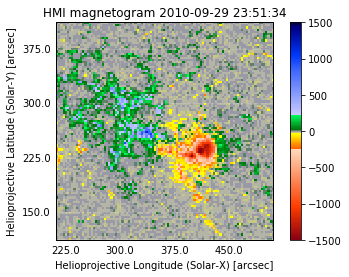

In [3]:
hmi_zoom_resampled.peek(cmap='hmimag',vmin=-1500,vmax=1500)

In [ ]:
extrapolator = ClassicalSchmidt(hmi_zoom_resampled, 0.5*sunpy.sun.constants.radius, 100*u.pixel)

In [ ]:
B_field = extrapolator.extrapolate()

In [ ]:
b_field_ds = synthesizAR.extrapolate.magnetic_field_to_yt_dataset(B_field.x,B_field.y,B_field.z,
                                                                  extrapolator.range.x,
                                                                  extrapolator.range.y,
                                                                  extrapolator.range.z)

In [ ]:
center=(b_field_ds.domain_center
        +np.array([0,0,-0.49])*b_field_ds.domain_width)
p = yt.ProjectionPlot(b_field_ds,'x','Bx',
                 #origin='lower-right-domain',
                 axes_unit='cm',
                 #center=center,
                 #width=((1*extrap_field.domain_width.value[1],'cm'),
                 #       (1*extrap_field.domain_width.value[2],'cm'))
                )
p.annotate_streamlines('By','Bz',density=2,plot_args={'color':'w'})
#p.set_zlim('Bz',-3e-2,3e-2)
#p.set_log('Bz',True,linthresh=1e-3)
p.show()

In [ ]:
def get_seed_points(ds, number_fieldlines, **kwargs):
    z0 = ds.domain_left_edge[2]
    seed_x = np.random.uniform(low=ds.domain_left_edge[0], high=ds.domain_right_edge[0], size=number_fieldlines)
    seed_y = np.random.uniform(low=ds.domain_left_edge[1], high=ds.domain_right_edge[1], size=number_fieldlines)
    
    return np.array([seed_x, seed_y ,number_fieldlines*[z0]]).T.tolist()


In [ ]:
seed_boundary = extrapolator.project_boundary(extrapolator.range.x, extrapolator.range.y).value
fieldlines= synthesizAR.extrapolate.trace_fieldlines(b_field_ds,hmi_zoom_resampled,1000,max_tries=100,
                                                     mask_threshold=0.15,
                                                     close_threshold=0.01,
                                                     safety=2,
                                                     #get_seed_points=get_seed_points,
                                                     loop_length_range=[1e9,2e10]*u.cm,
                                                     lower_boundary=seed_boundary)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=hmi_zoom_resampled)
### Map ###
im = hmi_zoom_resampled.plot(title=False,annotate=False,
                             vmin=-1.5e3,vmax=1.5e3,
                             cmap='hmimag')
ax.grid(alpha=0)
hmi_zoom_resampled.draw_grid(axes=ax,grid_spacing=10*u.deg,color='k',alpha=0.75)
#fig.colorbar(im)
### Expand View ###
#ax.plot_coord(SkyCoord(Tx=100*u.arcsec,Ty=50*u.arcsec,frame='helioprojective',
#                       observer=hmi_zoom.observer_coordinate),'ow')
#ax.plot_coord(SkyCoord(Tx=700*u.arcsec,Ty=600*u.arcsec,frame='helioprojective',
#                       observer=hmi_zoom.observer_coordinate),'ow')
## Fieldlines ####
for line,mag in fieldlines[::10]:
    line = u.Quantity(line,u.cm)
    x_hcc,y_hcc,z_hcc = synthesizAR.util.heeq_to_hcc(
        *synthesizAR.extrapolate.local_to_heeq(line[:,0],line[:,1],line[:,2],hmi_zoom_resampled.center),
        hmi_zoom_resampled.observer_coordinate
    )
    ax.plot_coord(SkyCoord(x_hcc,y_hcc,z_hcc,
                           frame=sunpy.coordinates.frames.Heliocentric,
                           observer=hmi_zoom_resampled.observer_coordinate
                          ).transform_to(hmi_zoom_resampled.coordinate_frame),
                  '-',lw=1,color='k',alpha=0.5)
    
### Seed Points ###
#seed_boundary = extrapolator.project_boundary(extrapolator.range.x, extrapolator.range.y).value
#seed_points = u.Quantity(synthesizAR.extrapolate.find_seed_points(b_field_ds, 1000, mask_threshold=0.05,
#                                                                  lower_boundary=seed_boundary),'cm')
#seed_points = synthesizAR.util.heeq_to_hcc(*synthesizAR.extrapolate.local_to_heeq(seed_points[:,0],
#                                                                                  seed_points[:,1],
#                                                                                  seed_points[:,2],
#                                                                                  hmi_zoom_resampled.center),
#                                           hmi_zoom_resampled.observer_coordinate)
#seed_coords = SkyCoord(x=seed_points[0],y=seed_points[1],z=seed_points[2],
#                       frame='heliocentric',observer=hmi_zoom_resampled.observer_coordinate)
#ax.plot_coord(seed_coords.transform_to(hmi_zoom_resampled.coordinate_frame), '.', color='k',alpha=0.5)

In [ ]:
for line,_ in fieldlines[::]:
    plt.plot(line[:,0],line[:,1],'k',alpha=0.1)

In [ ]:
local_grid_x,local_grid_y = np.meshgrid(
    np.linspace(extrapolator.range.x[0],extrapolator.range.x[1],int(extrapolator.shape.x.value)),
    np.linspace(extrapolator.range.y[0],extrapolator.range.y[1],int(extrapolator.shape.y.value)),
)
local_grid_z = np.zeros(local_grid_x.shape) * local_grid_x.unit

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=hmi_zoom_resampled)
### Map ###
im = hmi_zoom_resampled.plot(title=False,annotate=False,
                             vmin=-1.5e3,vmax=1.5e3,
                             cmap='hmimag')
ax.grid(alpha=0)
hmi_zoom_resampled.draw_grid(axes=ax,grid_spacing=10*u.deg,color='k',alpha=0.75)
# Local grid points
grid_x = local_grid_x[::5,::5].flatten()
grid_y = local_grid_y[::5,::5].flatten()
grid_z = local_grid_z[::5,::5].flatten()
grid_points = synthesizAR.util.heeq_to_hcc(*synthesizAR.extrapolate.local_to_heeq(grid_x,grid_y,grid_z,
                                                                                  hmi_zoom_resampled.center),
                                           hmi_zoom_resampled.observer_coordinate)
grid_coords = SkyCoord(x=grid_points[0],y=grid_points[1],z=grid_points[2],
                       frame='heliocentric',observer=hmi_zoom_resampled.observer_coordinate)
ax.plot_coord(grid_coords.transform_to(hmi_zoom_resampled.coordinate_frame), '+', color='k',alpha=1)

In [ ]:
plt.imshow(np.flipud(extrapolator.project_boundary(extrapolator.range.x,extrapolator.range.y)))

In [ ]:
l_hat = hmi_zoom_resampled.observer_coordinate.transform_to(
    sunpy.coordinates.frames.Heliocentric(observer=hmi_zoom_resampled.observer_coordinate))
origin = hmi_zoom_resampled.center.transform_to(
    sunpy.coordinates.frames.Heliocentric(observer=hmi_zoom_resampled.observer_coordinate))

In [ ]:
l_hat_heeq = u.Quantity(synthesizAR.util.to_heeq(l_hat))

In [ ]:
synthesizAR.extrapolate.heeq_to_local(*u.Quantity(synthesizAR.util.to_heeq(l_hat))[:,np.newaxis],hmi_zoom_resampled.center)

In [ ]:
fieldlines[0][1]

In [ ]:
u.Quantity([1],str(b_field_ds.r['Bz'].units))

In [ ]:
b_field_ds.field_info

In [ ]:
f1 = np.random.rand(100)
f2 = np.random.rand(100)
f3 = np.random.rand(100)
np.stack([f1,f2,f3],axis=1).shape

In [ ]:
foo = u.Quantity(fieldlines[0][0],'cm')
u.Quantity(np.stack(synthesizAR.extrapolate.local_to_heeq(*foo.T,hmi_zoom_resampled.center),axis=1)).shape

In [ ]:
foo.shape

In [ ]:
fieldlines[0][0].shape

## Sandbox

In [4]:
extrap = synthesizAR.extrapolate.ObliqueSchmidt(hmi_zoom_resampled, 0.5*sunpy.sun.constants.radius, 100*u.pixel)

In [5]:
B_field = extrap.extrapolate()

In [ ]:
ds = extrap.as_yt(B_field)

In [ ]:
center=(ds.domain_center + np.array([0,0,0])*ds.domain_width)
p = yt.SlicePlot(ds,'z','Bz',
                 #origin='lower-right-domain',
                 axes_unit='cm',
                 center=center,
                 #width=((1*extrap_field.domain_width.value[1],'cm'),
                 #       (1*extrap_field.domain_width.value[2],'cm'))
                )
p.annotate_streamlines('Bx','By',density=2,plot_args={'color':'w'})
#p.set_zlim('Bz',-3e-2,3e-2)
#p.set_log('Bz',True,linthresh=1e-3)
p.show()

In [8]:
fieldlines = extrap.trace_fieldlines(B_field,1000)

yt : [INFO     ] 2018-02-06 01:08:30,608 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-02-06 01:08:30,610 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-02-06 01:08:30,612 Parameters: domain_left_edge          = [ -1.27868860e+10  -1.01078828e+10   0.00000000e+00]
yt : [INFO     ] 2018-02-06 01:08:30,614 Parameters: domain_right_edge         = [  1.48655136e+10   1.13017197e+10   3.47754000e+10]
yt : [INFO     ] 2018-02-06 01:08:30,616 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-02-06 01:08:31,118 AMRKDTree rebuilt, Final Volume: 2.058797e+31
Streamlining: 100%|██████████| 1000/1000 [00:01<00:00, 567.37it/s]
yt : [INFO     ] 2018-02-06 01:08:33,805 AMRKDTree rebuilt, Final Volume: 2.058797e+31
Streamlining: 100%|██████████| 262/262 [00:00<00:00, 575.93it/s]
yt : [INFO     ] 2018-02-06 01:08:34,684 AMRKDTree rebuilt, Final Volume: 2.058797e+31
Streamlining: 100%|██████████| 68/68 [00:00<00:00, 499.77it/s]
yt : [INFO 

In [6]:
seed_boundary = extrap.project_boundary(extrap.range.x, extrap.range.y).value
fieldlines= synthesizAR.extrapolate.trace_fieldlines(ds,1000,
                                                     #max_tries=100,
                                                     #mask_threshold=0.15,
                                                     #close_threshold=0.01,
                                                     #safety=2,
                                                     #get_seed_points=get_seed_points,
                                                     #loop_length_range=[1e9,2e10]*u.cm,
                                                     lower_boundary=seed_boundary)

NameError: name 'ds' is not defined

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=hmi_zoom_resampled)
### Map ###
im = hmi_zoom_resampled.plot(title=False,annotate=False,
                             vmin=-1.5e3,vmax=1.5e3,
                             cmap='hmimag')
ax.grid(alpha=0)
hmi_zoom_resampled.draw_grid(axes=ax,grid_spacing=10*u.deg,color='k',alpha=0.75)
## Fieldlines ####
for line,_ in fieldlines[::2]:
    #line = u.Quantity(line,u.cm)
    #line_heeq = u.Quantity(synthesizAR.extrapolate.local_to_heeq(*line.T,extrap.magnetogram.center)).T
    #x_hcc,y_hcc,z_hcc = synthesizAR.util.heeq_to_hcc(
    #    *synthesizAR.extrapolate.local_to_heeq(line[:,0],line[:,1],line[:,2],hmi_zoom_resampled.center),
    #    hmi_zoom_resampled.observer_coordinate
    #)
    x_hcc,y_hcc,z_hcc = synthesizAR.util.heeq_to_hcc(line[:,0],line[:,1],line[:,2],
                                                     hmi_zoom_resampled.observer_coordinate)
    ax.plot_coord(SkyCoord(x_hcc,y_hcc,z_hcc,
                           frame=sunpy.coordinates.frames.Heliocentric,
                           observer=hmi_zoom_resampled.observer_coordinate
                          ).transform_to(hmi_zoom_resampled.coordinate_frame),
                  '-',lw=1,color='k',alpha=0.5)

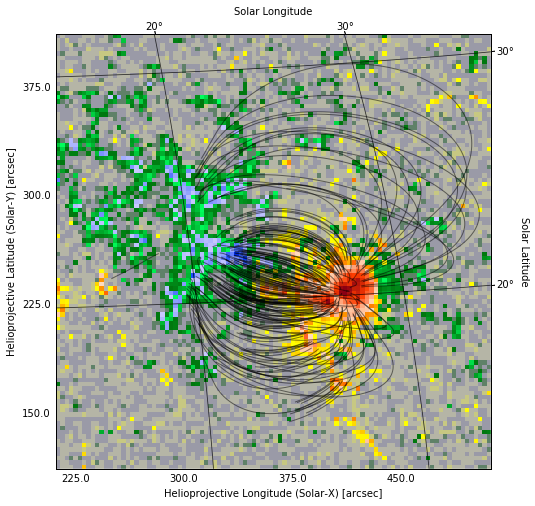

In [11]:
extrap.peek([f[0] for f in fieldlines])

In [12]:
field = synthesizAR.Field(hmi_zoom_resampled,fieldlines=fieldlines)

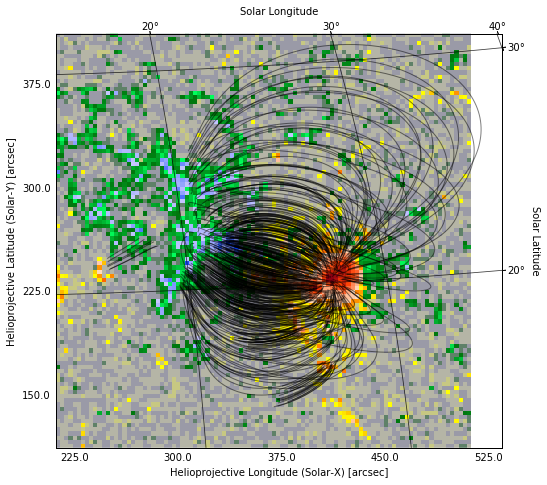

In [14]:
field.peek(line_frequency=2)

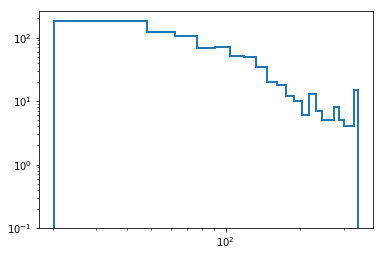

In [21]:
plt.hist([loop.full_length.to(u.Mm).value for loop in field.loops], histtype='step', lw=2,bins='fd', log=True);
plt.xscale('log')